# StackOverflowData

In [ ]:
import numpy as np
from collections import Counter
from operator import itemgetter
from sklearn import metrics



# if you have labels


'''
    The idea of the function below (map_label) is a simplified approach to what they did in the initial paper. 
    They used the so called Hungarian method in order to optimize the labeling. The optimization is based on the
    ground truth and the labels from the k clustering. Using the example dataset:
    We have 20 000 items split in 20 categories, which means that a certain category has multiple items. 
    The idea of best mapping is to take all tuples from ground truth and prediction per item and count their 
    occurancies. For example (6, 18), 88), 6 being the ground truth and 18 the prediction truth. This 
    combination has occured 88 times but ((6, 3), 116) has occured 116 times, so at the end the function 
    will return 6,3 as best map.
'''


import munkres
from sklearn.metrics.cluster import contingency_matrix
def translateLabels(masterList, listToConvert):    
    contMatrix = contingency_matrix(masterList, listToConvert)
    labelMatcher = munkres.Munkres()
    labelTranlater = labelMatcher.compute(contMatrix.max() - contMatrix)

    uniqueLabels1 = list(set(masterList))
    uniqueLabels2 = list(set(listToConvert))

    tranlatorDict = {}
    for thisPair in labelTranlater:
        tranlatorDict[uniqueLabels2[thisPair[1]]] = uniqueLabels1[thisPair[0]]

    return [tranlatorDict[label] for label in listToConvert]


from munkres import Munkres
def best_map(L1,L2):
    #L1 should be the groundtruth labels and L2 should be the clustering labels we got
    Label1 = np.unique(L1)
    nClass1 = len(Label1)
    Label2 = np.unique(L2)
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1,nClass2)
    G = np.zeros((nClass,nClass))
    for i in range(nClass1):
        ind_cla1 = L1 == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = L2 == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i,j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:,1]
    newL2 = np.zeros(L2.shape)
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]
    return newL2 



def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())  #count the appearance of each pair dict principle
    mapping = dict()
    n_label = len(np.unique(true_labels))

    # map most likely labels from prediction to ground truth

    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0] # tuple as input and take the one which appears the most from the list
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped

# if you have labels
def cluster_quality(true_labels, pred_labels, show=True):
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    pred_labels_mapped = map_label(true_labels, pred_labels) # initial version
    #pred_labels_mapped = best_map(true_labels, pred_labels) # 1st test - around 52,5%
    #pred_labels_mapped = translateLabels(true_labels, pred_labels) # good results but around 49% with big deviation up to 55,8
    acc = metrics.accuracy_score(true_labels, pred_labels_mapped)
    '''
    if show:
        print("Homogeneity: %0.3f" % h)
        print("Completeness: %0.3f" % c)
        print("V-measure: %0.3f" % v)
        print("NMI: %0.3f" % nmi)
        print("Rand score: %0.3f" % rand)
        print("Accuracy: %0.3f" % acc)
        '''
    return dict(
        homogeneity=round(h,3),
        completeness=round(c,3),
        vmeasure=round(v,3),
        nmi=round(nmi,3),
        rand=round(rand,3),
        accuracy=round(acc,3),
    )


In [ ]:
import os

from gensim.models.keyedvectors import KeyedVectors
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

############################
# Loading Data
############################

EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin' # word vectors
text_path = 'data/StackOverflow.txt'# data without labels
#text_path = 'data/blq.txt'# data without labels - Own Data
label_path = 'data/StackOverflow_gnd.txt' # labels per row in the data file

with open(text_path) as f:
    data = [text.strip() for text in f]

with open(label_path) as f:
    target = f.readlines()
    
target = [int(label.rstrip('\n')) for label in target] # the data has /n at the end of each row

print("Total: %s short texts" % format(len(data), ","))

In [ ]:
############################
# Preprocessing
############################

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data) # replace words/tokens with numbers

word_index = tokenizer.word_index # get the coresponing word:number dict format
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index) # all words - len

seq_lens = [len(s) for s in sequences_full] # get the count of words/symbols in the sequence from above
print("Minumum length: %d" % min(seq_lens))
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH) # uses the len of the list and max len
y = target # we take the target values

'''
    pad_sequences is used to ensure that all sequences in a list have the same length. By default this 
    is done by padding 0 in the beginning of each sequence until each sequence has the same 
    length as the longest sequence.
'''

In [ ]:
############################
# Preparing embedding matrix
############################


print('Preparing embedding matrix')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) # Init as 0's and updated if in word2vec
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    #else:
        #print(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

In [ ]:
#################################################
# Preparing target using Average embeddings (AE)
#################################################
Y = {}
tfidf = tokenizer.sequences_to_matrix(sequences_full, mode='tfidf') # converting List of sequences (a sequence is a list of integer word indices).
# TF-IDF Acc: 0,329
binary_seq = tokenizer.sequences_to_matrix(sequences_full, mode='binary') # Acc: 0,458
count_seq = tokenizer.sequences_to_matrix(sequences_full, mode='count') # Acc: 0,467
frequency_seq = tokenizer.sequences_to_matrix(sequences_full, mode='freq') # Acc: 0452
from sklearn.preprocessing import Normalizer
normed = Normalizer().fit_transform(count_seq)
average_embeddings = np.dot(normed, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)


# binary Y
from sklearn import preprocessing
reduction_name = "ae"
B = preprocessing.Binarizer().fit_transform(Y[reduction_name]) # binarizing the whole value list for ae key (which is the only key)

# Last dimension in the CNN
TARGET_DIM = B.shape[1]

# Example of binarized target vector
print(B.shape)
print(B[1])

In [ ]:
data[1]

In [ ]:
import sys
import numpy
# https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.set_printoptions.html
numpy.set_printoptions(threshold=sys.maxsize)
print(tfidf[1])

In [ ]:
print(binary_seq[1])

In [ ]:
print(count_seq[1])

In [ ]:
print(frequency_seq[1])

In [ ]:
###############PLAYING-GridSearch#################################
# Playing train model
################################################

# Best accuracy for now

import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, concatenate, Input
from keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint

#https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
# the above link has to do with dropout positioning

# https://github.com/keras-team/keras/issues/7290
# has to do with spatial dropout after embedding layer

# https://towardsdatascience.com/review-tompson-cvpr15-spatial-dropout-human-pose-estimation-c7d6a5cecd8c
# SpatialDropout again

def get_model():
    embedding_matrix_copy = embedding_matrix.copy()
    trainable_embedding = False
    #filters = [2,3,4]
    filters = [3,4,5]
    # Embedding layer
    pretrained_embedding_layer = Embedding(
        input_dim=nb_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
    )

    # Input
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = pretrained_embedding_layer(sequence_input)
    
    # DropOut
    #x = Dropout(0.2)(embedded_sequences)
    spatial_x = SpatialDropout1D(0.1)(embedded_sequences)
    
    # 1st Layer
    conv_layers = []
    for i in filters:
        x = Conv1D(125, i, activation='tanh', padding='same')(spatial_x)
        x = GlobalMaxPooling1D()(x)
        #x = Dropout(0.2)(x)
        conv_layers.append(x)
    merged = concatenate(conv_layers)
    # Dense
    x = Dense(256,activation = 'tanh')(merged)
    
    # DropOut
    x = Dropout(0.1)(x)
    
    # Output
    predictions = Dense(TARGET_DIM, activation='sigmoid')(x) 
    # sigmoid because we want 0,1 for one of the categories
    
    model = Model(sequence_input, predictions)

    model.layers[1].trainable=trainable_embedding #embedding layer

    #adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #standard for keras
    #optimizer = Adam(lr=learn_rate)
    
    # Loss and Optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy','mae'])
    
    # Fine-tune embeddings or not
    model.summary()
    
    return model

In [ ]:
# Grid Search with best model
# Use scikit-learn to grid search the number of neurons
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
model = KerasClassifier(build_fn=get_model, epochs=50, batch_size=100,verbose=0)

# define the grid search parameters

#activ = ['relu', 'tanh', 'sigmoid']
#optimizers = ['Nadam','Adam']
droupou = [0.1,0.2,0.4,0.5,0.6]
#init_mode = ['uniform', 'lecun_uniform']
#filters =[100,120]
#size = [100,120,125]
#filterme = [[3,4,5], [2,3,4]]
#batch_size = [200]
#epochs = [120]
#learn_rate = [0.001, 0.01, 0.02, 0.1]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(droupout = droupou)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs= -1)
grid_result = grid.fit(X, B)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# 25 epoch and 80 batch = 50.3 accuracy
nb_epoch = 50
checkpoint = ModelCheckpoint('models/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model = get_model()
history = model.fit(X, B, validation_split=0.2,
              epochs=nb_epoch, batch_size=100, verbose=1, shuffle=True)

# create model that gives penultimate layer (предпоследно)
input1 = model.layers[0].input
output = model.layers[-2].output

model_penultimate = Model(input1, output)

# inference of penultimate layer
H = model_penultimate.predict(X)
print("Sample shape: {}".format(H.shape))

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

true_labels = y
n_clusters = len(np.unique(y))
#n_clusters = 27 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result = dict()
V = normalize(H, norm='l2')
km.fit(V)
pred = km.labels_
pred1 = km.cluster_centers_
print(pred)
a = cluster_quality(true_labels, pred)
#np.save("pred.npy", pred)
print(a)


# Running clusterS

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# clustering loop
true_labels = y
n_clusters = len(np.unique(y))
#n_clusters = 27 # for own data
#print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result = dict()
V = normalize(H, norm='l2')
df = pd.DataFrame()
for i in range(50):
    km.fit(V)
    pred = km.labels_
    pred1 = km.cluster_centers_
    #print(pred)
    a = cluster_quality(true_labels, pred)
    df = df.append([a],ignore_index=True)
   

In [ ]:
# round up this and the ones below in function to end up with a table for the paper
dfToList = df['accuracy'].tolist()
lenList = len(dfToList)
sumMe = 0
for i in dfToList:
    sumMe += i
df['average_acc'] = round(sumMe/lenList,3)
df['diff_acc'] = df.apply(lambda x: (x['accuracy'] - x['average_acc']), axis=1)


In [ ]:
# using tfidf
df_tfidf = df
max_acc = df_tfidf['accuracy'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))
min_acc = df_tfidf['accuracy'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))
average_acc = df_tfidf['average_acc'].max() # 0.514
print('Average accuracy is: {}'.format(average_acc))
df_tfidf

In [ ]:
# using count
df_count = df
max_acc = df_count['accuracy'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))
min_acc = df_count['accuracy'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))
average_acc = df_count['average_acc'].max() # 0.514
print('Average accuracy is: {}'.format(average_acc))
df_count

In [ ]:
# using frequency
df_freq = df
max_acc = df_freq['accuracy'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))
min_acc = df_freq['accuracy'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))
average_acc = df_freq['average_acc'].max() # 0.514
print('Average accuracy is: {}'.format(average_acc))
df_freq

In [ ]:
# using binary
df_binary = df
max_acc = df_binary['accuracy'].max() # 0,581
print('Max accuracy is: {}'.format(max_acc))
min_acc = df_binary['accuracy'].min() # 0.463
print('Min accuracy is: {}'.format(min_acc))
average_acc = df_binary['average_acc'].max() # 0.514
print('Average accuracy is: {}'.format(average_acc))
df_binary

# Save/Load Model 

In [ ]:
from keras.models import model_from_json
# Saving Model and weiths
# serialize model to JSON
model_json = model.to_json()
with open("hippo_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("hippo_model.h5")
print("Saved model to disk")
 
# load json and create model
json_file = open('hippo_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("hippo_model.h5")
print("Loaded model from disk")

# Evaluate

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))



# HippoData

In [1]:
import numpy as np
from collections import Counter
from operator import itemgetter
from sklearn import metrics



# if you have labels


'''
    The idea of the function below (map_label) is a simplified approach to what they did in the initial paper. 
    They used the so called Hungarian method in order to optimize the labeling. The optimization is based on the
    ground truth and the labels from the k clustering. Using the example dataset:
    We have 20 000 items split in 20 categories, which means that a certain category has multiple items. 
    The idea of best mapping is to take all tuples from ground truth and prediction per item and count their 
    occurancies. For example (6, 18), 88), 6 being the ground truth and 18 the prediction truth. This 
    combination has occured 88 times but ((6, 3), 116) has occured 116 times, so at the end the function 
    will return 6,3 as best map.
'''

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())  #count the appearance of each pair dict principle
    mapping = dict()
    n_label = len(np.unique(true_labels))

    # map most likely labels from prediction to ground truth

    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0] # tuple as input and take the one which appears the most from the list
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped

# if you have labels
def cluster_quality(true_labels, pred_labels, show=True):
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    pred_labels_mapped = map_label(true_labels, pred_labels)
    acc = metrics.accuracy_score(true_labels, pred_labels_mapped)
    '''
    # Prints the scores
    if show:
        print("Homogeneity: %0.3f" % h)
        print("Completeness: %0.3f" % c)
        print("V-measure: %0.3f" % v)
        print("NMI: %0.3f" % nmi)
        print("Rand score: %0.3f" % rand)
        print("Accuracy: %0.3f" % acc)
        '''
    return dict(
        homogeneity=round(h,3),
        completeness=round(c,3),
        vmeasure=round(v,3),
        nmi=round(nmi,3),
        rand=round(rand,3),
        accuracy=round(acc,3),
    )


In [2]:
import os

from gensim.models.keyedvectors import KeyedVectors
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

############################
# Loading Data
############################

EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin' # word vectors
text_path = 'data/StackOverflow.txt'# data without labels
#text_path = 'data/data_NN.txt'# data without labels - Own Data
#text_path = 'data/data_NN_Scrapped.txt'# data without labels - Own Data based on scrapping
label_path = 'data/StackOverflow_gnd.txt' # labels per row in the data file

with open(text_path) as f:
    data = [text.strip() for text in f]

with open(label_path) as f:
    target = f.readlines()
    
target = [int(label.rstrip('\n')) for label in target] # the data has /n at the end of each row

print("Total: %s short texts" % format(len(data), ","))

Using TensorFlow backend.


Total: 20,000 short texts


In [3]:
############################
# Preprocessing
############################

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data) # replace words/tokens with numbers

word_index = tokenizer.word_index # get the coresponing word:number dict format
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index) # all words - len

seq_lens = [len(s) for s in sequences_full] # get the count of words/symbols in the sequence from above
print("Minumum length: %d" % min(seq_lens))
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH) # uses the len of the list and max len
y = target # we take the target values

'''
    pad_sequences is used to ensure that all sequences in a list have the same length. By default this 
    is done by padding 0 in the beginning of each sequence until each sequence has the same 
    length as the longest sequence.
'''

Found 11365 unique tokens.
Minumum length: 1
Average length: 8
Max length: 34


'\n    pad_sequences is used to ensure that all sequences in a list have the same length. By default this \n    is done by padding 0 in the beginning of each sequence until each sequence has the same \n    length as the longest sequence.\n'

In [4]:
############################
# Preparing embedding matrix
############################


print('Preparing embedding matrix')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM)) # Init as 0's and updated if in word2vec
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
    #else:
        #print(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 4269


In [5]:
#################################################
# Preparing target using Average embeddings (AE)
#################################################
Y = {}
tfidf_seq = tokenizer.sequences_to_matrix(sequences_full, mode='tfidf') # converting List of sequences (a sequence is a list of integer word indices).
# TF-IDF Acc: 0,329
binary_seq = tokenizer.sequences_to_matrix(sequences_full, mode='binary') # Acc: 0,458
count_seq = tokenizer.sequences_to_matrix(sequences_full, mode='count') # Acc: 0,467
frequency_seq = tokenizer.sequences_to_matrix(sequences_full, mode='freq') # Acc: 0452
from sklearn.preprocessing import Normalizer
normed_value = Normalizer().fit_transform(count_seq)
average_embeddings = np.dot(normed_value, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)


# binary Y
from sklearn import preprocessing
reduction_name = "ae"
B = preprocessing.Binarizer().fit_transform(Y[reduction_name]) # binarizing the whole value list for ae key (which is the only key)

# Shape of last dimension in the CNN
TARGET_DIM = B.shape[1]

# Example of binarized target vector
print(B.shape)
print(B[1])

Shape of average embedding:  (20000, 300)
(20000, 300)
[1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]


In [39]:
###############PLAYING-GridSearch#################################
# Playing train model
################################################

# Best accuracy for now

import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, concatenate, Input
from keras.layers import Embedding, Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

#https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
# the above link has to do with dropout positioning

# https://github.com/keras-team/keras/issues/7290
# has to do with spatial dropout after embedding layer

# https://towardsdatascience.com/review-tompson-cvpr15-spatial-dropout-human-pose-estimation-c7d6a5cecd8c
# SpatialDropout again

def get_model():
    embedding_matrix_copy = embedding_matrix.copy()
    trainable_embedding = False
    #filters = [2,3,4]
    filters = [3,4,5]
    
    # Embedding layer
    pretrained_embedding_layer = Embedding(
        input_dim=nb_words,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
    )

    # Input
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = pretrained_embedding_layer(sequence_input)
    
    # DropOut
    #x = Dropout(0.2)(embedded_sequences)
    spatial_x = SpatialDropout1D(0.1)(embedded_sequences)
    
    # 1st Layer
    conv_layers = []
    for i in filters:
        x = Conv1D(125, i, activation='tanh', padding='same')(spatial_x)
        x = GlobalMaxPooling1D()(x)
        #x = Dropout(0.2)(x)
        conv_layers.append(x)
    merged = concatenate(conv_layers)
    
    # Dense
    #x = Dense(TARGET_DIM,activation = 'tanh')(merged)
    x = Dense(256,activation = 'tanh')(merged) # best performing
    
    # DropOut
    x = Dropout(0.1)(x)
    #x = Dropout(0.1)(merged) # best performing
    
    # Output
    predictions = Dense(TARGET_DIM, activation='sigmoid')(x) 
    # sigmoid because we want 0,1 for one of the categories
    
    model = Model(sequence_input, predictions)

    model.layers[1].trainable=trainable_embedding #embedding layer

    #adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #standard for keras
    #optimizer = Adam(lr=learn_rate)
    
    # Loss and Optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy','mae'])
    
    # Fine-tune embeddings or not
    model.summary()
    plot_model(model, to_file='model_plot_no_shapes.png', show_shapes=False, show_layer_names=True)

    
    return model

In [40]:
from sklearn.preprocessing import normalize
# 25 epoch and 80 batch = 50.3 accuracy
nb_epoch = 50 #changed from 50 cause of time limitations

# 5 epochs take 1 hour and 14 mins to load

checkpoint = ModelCheckpoint('models/weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model = get_model()
history = model.fit(X, B, validation_split=0.2,
              epochs=nb_epoch, batch_size=100, verbose=1, shuffle=True)

# create model that gives penultimate layer (предпоследно)
input1 = model.layers[0].input
output = model.layers[-2].output

model_penultimate = Model(input1, output)


# inference of penultimate layer
#H_penul = model_penultimate.predict(X)
#print("Sample shape: {}".format(H_penul.shape))
#V_penul = normalize(H_penul, norm='l2') # nomr
# standard model prediction
#H_standard = model.predict(X)
#print("Sample shape for standard: {}".format(H_standard.shape))
#V_standard = normalize(H_standard, norm='l2') # norm


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 300)      3409800     input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 34, 300)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 34, 125)      112625      spatial_dropout1d_4[0][0]        
__________________________________________________________________________________________________
conv1d_11 

16000/16000 [==============================] - 15s 919us/step - loss: 0.2547 - acc: 0.8887 - mean_absolute_error: 0.1636 - val_loss: 0.2924 - val_acc: 0.8692 - val_mean_absolute_error: 0.1807
Epoch 26/50
16000/16000 [==============================] - 14s 887us/step - loss: 0.2535 - acc: 0.8894 - mean_absolute_error: 0.1626 - val_loss: 0.2918 - val_acc: 0.8695 - val_mean_absolute_error: 0.1798
Epoch 27/50
16000/16000 [==============================] - 14s 904us/step - loss: 0.2522 - acc: 0.8901 - mean_absolute_error: 0.1615 - val_loss: 0.2909 - val_acc: 0.8698 - val_mean_absolute_error: 0.1796
Epoch 28/50
16000/16000 [==============================] - 14s 902us/step - loss: 0.2508 - acc: 0.8906 - mean_absolute_error: 0.1605 - val_loss: 0.2906 - val_acc: 0.8703 - val_mean_absolute_error: 0.1782
Epoch 29/50
16000/16000 [==============================] - 15s 919us/step - loss: 0.2500 - acc: 0.8908 - mean_absolute_error: 0.1598 - val_loss: 0.2898 - val_acc: 0.8708 - val_mean_absolute_error:

In [41]:
# inference of penultimate layer
H_penul = model_penultimate.predict(X)
print("Sample shape: {}".format(H_penul.shape))

Sample shape: (20000, 256)


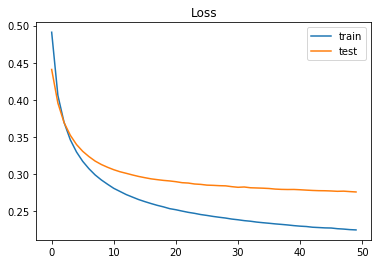

In [31]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

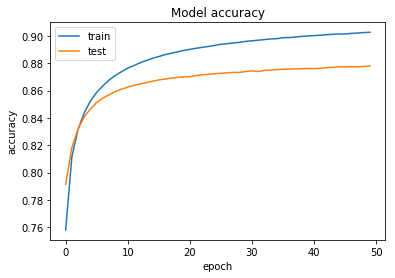

In [32]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Amount of Clusters based on Penul data
# Wherever it makes the curve switch - around 6-7 for this data

import numpy as np
from scipy import cluster
from matplotlib import pyplot

#V = normalize(H, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
#plot variance for each value for 'k' between 1,10
initial = [cluster.vq.kmeans(V_penul,i) for i in range(1,40)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

In [ ]:
# Amount of Clusters based on standard prediction
# Wherever it makes the curve switch - around 6-7 for this data

import numpy as np
from scipy import cluster
from matplotlib import pyplot

#V = normalize(H, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
#plot variance for each value for 'k' between 1,10
initial = [cluster.vq.kmeans(V_standard,i) for i in range(1,40)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()

In [43]:
# First run

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

true_labels = y
n_clusters = len(np.unique(y))
#n_clusters = 7 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result_penul = dict()
V_penul = normalize(H_penul, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
km.fit(V_penul)
pred_penul = km.labels_
pred1_penul = km.cluster_centers_
print(pred_penul)
a = cluster_quality(true_labels, pred_penul) #needs labels
#np.save("pred.npy", pred)
print(a)

Number of classes: 20
[14 14  8 ...  9  9  0]
{'homogeneity': 0.507, 'completeness': 0.535, 'vmeasure': 0.521, 'nmi': 0.521, 'rand': 0.318, 'accuracy': 0.569}


/Users/Dimitar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

#true_labels = y
#n_clusters = len(np.unique(y))
n_clusters = 7 # for own data
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result_standard = dict()
#V = normalize(H_penul, norm='l2') # https://machinelearningmastery.com/vector-norms-machine-learning/
km.fit(V_standard)
pred_standard = km.labels_
pred1_standard = km.cluster_centers_
print(pred_standard)
#a = cluster_quality(true_labels, pred) #needs labels
#np.save("pred.npy", pred)


# Visualization - Evaluation

In [ ]:
#################################################
################Visualization####################
#################################################

In [ ]:

y_kmeans = km.predict(V)

plt.scatter(V[:, 0], V[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=13, alpha=0.5);

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(a, 13) #gives error for some reason
plt.scatter(a[:, 0], a[:, 1], c=labels,
            s=50, cmap='viridis');

In [ ]:

# DBSCAN for penul layer based on scrapped keywords

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################


X = StandardScaler().fit_transform(V_penul)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples= 10).fit(V_penul)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pred_penul, labels))
print("Completeness: %0.3f" % metrics.completeness_score(pred_penul, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(pred_penul, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(pred_penul, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(pred_penul, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result - DBSCAN
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o',
     #        markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:

# DBSCAN for standard prediction based on scrapped keywords

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################


X = StandardScaler().fit_transform(V_standard)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples= 10).fit(V_standard)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pred_standard, labels))
print("Completeness: %0.3f" % metrics.completeness_score(pred_standard, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(pred_standard, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(pred_standard, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(pred_standard, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o',
     #        markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Evaluation

In [ ]:
#################################################
################Evaluation####################
#################################################

In [ ]:

# Running the results from standard prediction based on Scrapped Keywords

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)
from matplotlib.backends.backend_pdf import PdfPages
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

pp = PdfPages('ScrappedKeywords_StandardPrediction200.pdf')


range_n_clusters = []
for i in range(2,201): # make a list from 1 till 31
    range_n_clusters.append(i)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(V_standard) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(V_standard)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(V_standard, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(V_standard, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(V_standard[:, 0], V_standard[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {} with Average Silhouette of: {}".format(n_clusters,silhouette_avg)),
                 fontsize=14, fontweight='bold')
    pp.savefig(fig)

plt.show()
pp.close()

In [ ]:

# Running the results from penul layer from Scrappe Keywords

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)
from matplotlib.backends.backend_pdf import PdfPages
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

pp = PdfPages('ScrappedKeywords_PenulLayer200.pdf')


range_n_clusters = []
for i in range(2,201): # make a list from 1 till 31
    range_n_clusters.append(i)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(V_penul) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(V_penul)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(V_penul, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(V_penul, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(V_penul[:, 0], V_penul[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {} with Average Silhouette of: {}".format(n_clusters,silhouette_avg)),
                 fontsize=14, fontweight='bold')
    pp.savefig(fig)

plt.show()
pp.close()

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)
from matplotlib.backends.backend_pdf import PdfPages
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

pp = PdfPages('TempMapping.pdf')


range_n_clusters = []
for i in range(2,101): # make a list from 1 till 31
    range_n_clusters.append(i)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(a) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(V_penul)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(V_penul, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(V_penul, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(V_penul[:, 0], V_penul[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {} with Average Silhouette of: {}".format(n_clusters,silhouette_avg)),
                 fontsize=14, fontweight='bold')
    pp.savefig(fig)

plt.show()
pp.close()

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)
from matplotlib.backends.backend_pdf import PdfPages
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

pp = PdfPages('Test_V_standard.pdf')


range_n_clusters = []
for i in range(2,101): # make a list from 1 till 31
    range_n_clusters.append(i)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(V_standard) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(V_standard)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(V_standard, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(V_standard, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(V_standard[:, 0], V_standard[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = {} with Average Silhouette of: {}".format(n_clusters,silhouette_avg)),
                 fontsize=14, fontweight='bold')
    pp.savefig(fig)

plt.show()
pp.close()

# Storing Locally

In [ ]:
data[1]

In [ ]:
sequences_full[1]

In [ ]:
X[1]

In [ ]:
H_standard[1]

In [ ]:
V_standard[1]

In [ ]:
pred_standard[1]

In [ ]:
pred1_standard[1]

In [ ]:
import pandas as pd
d = []
for i in range(len(data)):
    d.append({'Keywords': data[i], 'Sequence_Full': sequences_full[i], 'Prediction':pred_standard[i]})
d = pd.DataFrame(d)
#d.sort_values('Prediction')
d.to_csv('CNN_Demo-HippoBased_Labels.csv')

In [ ]:
d.reset_index().plot.scatter(x='index', y='Prediction')

In [ ]:
d["Prediction"].value_counts().plot.bar()

In [ ]:
d.sort_values('Prediction')